# Stock price prediction using RNNs

## Setup and imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from pathlib import Path
from typing import Callable

import numpy as np
import numpy.typing as npt
import pandas as pd

from load_google_data import load_google_stock_data, unnormalise
from activation_functions import elu, leaky_relu, relu, sigmoid, tanh
from rnn import RNN

## Loading data

In [3]:
# Paths to training and testing data
train_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Train.csv"
)
test_filepath = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/Google_Stock_Price_Test.csv"
)


train_data, normalisation_params = load_google_stock_data(train_filepath)
test_data, _ = load_google_stock_data(test_filepath)

## Creating sequences of data

In [4]:
# Create sequences for training (sequence_length is the number of past days to predict the next day)
def create_sequences(
    data: pd.DataFrame, sequence_length: int
) -> list[tuple[npt.NDArray[np.float32], float]]:
    np_data = data[["Open", "High", "Low", "Close", "Volume"]].to_numpy(np.float32)

    sequences = []
    for i in range(len(np_data) - sequence_length):
        seq = np_data[i : i + sequence_length, :]
        target = float(
            np_data[i + sequence_length, 3]
        )  # 'Close' value on final day of sequence as target
        sequences.append((seq, target))
    return sequences

## Training function

In [5]:
# Training Function
def train_rnn(
    rnn: RNN,
    train_sequences: list[tuple[pd.Series, pd.Series]],
    epochs: int = 10,
    learning_rate: float = 0.01,
) -> None:
    for epoch in range(epochs):
        losses = []
        for seq, target in train_sequences:
            rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state
            inputs = [x.reshape(-1, 1) for x in seq]  # Prepare sequence as input

            # Calculate the prediction for this sequence of inputs
            prediction = rnn.forward(inputs)

            # Calculate individual loss as squared error
            loss = (prediction - target) ** 2
            losses.append(loss)

            # Backward pass
            rnn.backward(inputs, target, prediction, learning_rate)

        # Calculate loss as MSE
        loss = sum(losses) / len(losses)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

## Test function

In [6]:
# Test the RNN
def test_rnn(
    rnn: RNN,
    test_data: pd.DataFrame,
    normalisation_params: dict[str, tuple[float, float]],
    sequence_length: int = 10,
) -> tuple[list[float], list[float]]:
    sequences = create_sequences(test_data, sequence_length)
    predictions: list[float] = []
    targets: list[float] = []

    min_close, max_close = normalisation_params["Close"]

    for seq, target in sequences:
        rnn.h = np.zeros((rnn.hidden_size, 1))  # Reset hidden state for each sequence

        # Step over full sequence
        for t in range(sequence_length):
            x = seq[t].reshape(-1, 1)  # Reshape to column vector (input_size, 1)
            rnn.step(x)  # Pass as a single timestep

        y_pred = np.dot(rnn.W_hy, rnn.h)  # Compute final output
        predictions.append(unnormalise(y_pred.ravel()[0], min_close, max_close))
        targets.append(unnormalise(target, min_close, max_close))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(targets)) ** 2))
    print(f"Test RMSE: {rmse:.4f}")

    return predictions, targets

## Train and Test Simple RNN

Epoch 1/20, Loss: 0.1000
Epoch 2/20, Loss: 0.0034
Epoch 3/20, Loss: 0.0021
Epoch 4/20, Loss: 0.0017
Epoch 5/20, Loss: 0.0015
Epoch 6/20, Loss: 0.0014
Epoch 7/20, Loss: 0.0014
Epoch 8/20, Loss: 0.0014
Epoch 9/20, Loss: 0.0014
Epoch 10/20, Loss: 0.0014
Epoch 11/20, Loss: 0.0013
Epoch 12/20, Loss: 0.0013
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0013
Epoch 15/20, Loss: 0.0013
Epoch 16/20, Loss: 0.0013
Epoch 17/20, Loss: 0.0013
Epoch 18/20, Loss: 0.0013
Epoch 19/20, Loss: 0.0013
Epoch 20/20, Loss: 0.0013
Test RMSE: 108.9549


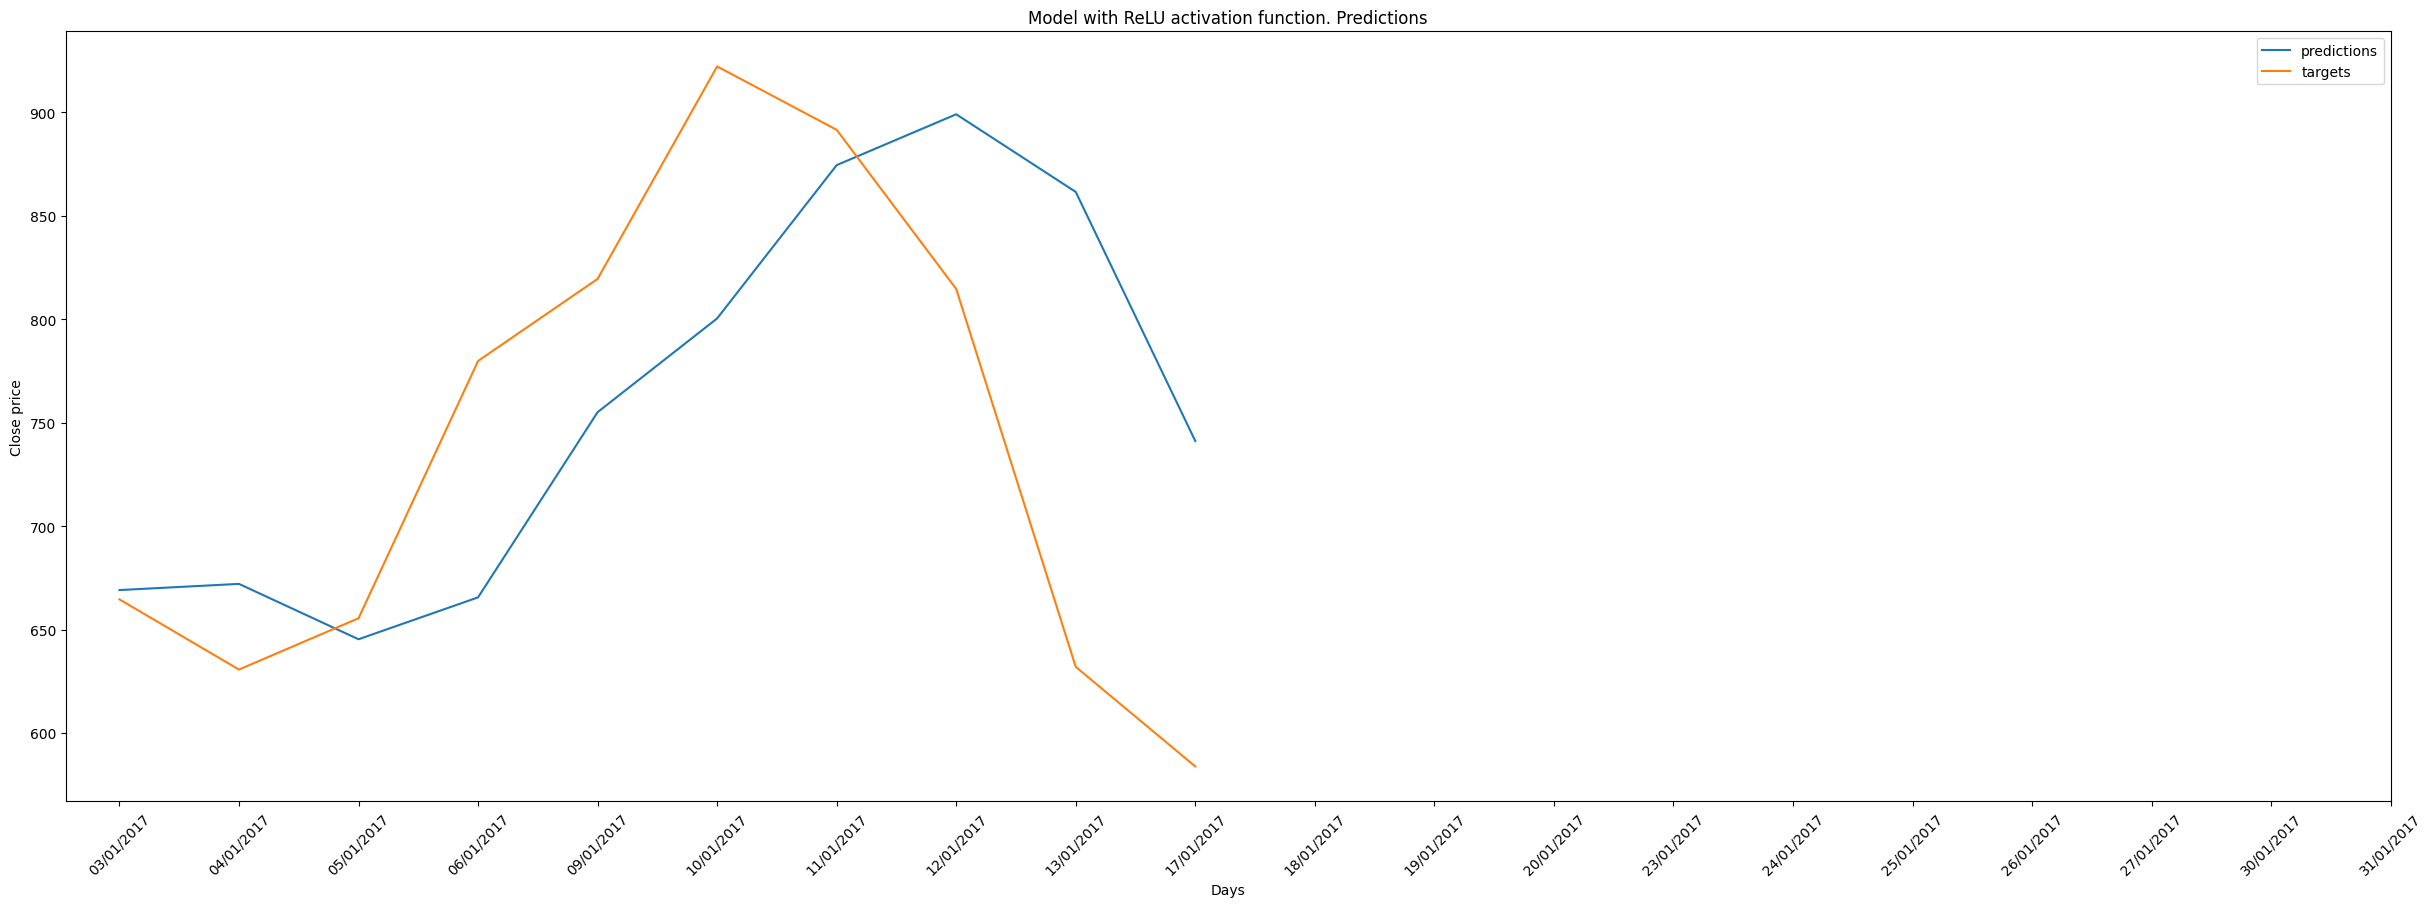

Epoch 1/20, Loss: 0.0999
Epoch 2/20, Loss: 0.0033
Epoch 3/20, Loss: 0.0021
Epoch 4/20, Loss: 0.0017
Epoch 5/20, Loss: 0.0015
Epoch 6/20, Loss: 0.0015
Epoch 7/20, Loss: 0.0014
Epoch 8/20, Loss: 0.0014
Epoch 9/20, Loss: 0.0014
Epoch 10/20, Loss: 0.0014
Epoch 11/20, Loss: 0.0014
Epoch 12/20, Loss: 0.0013
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0013
Epoch 15/20, Loss: 0.0013
Epoch 16/20, Loss: 0.0013
Epoch 17/20, Loss: 0.0013
Epoch 18/20, Loss: 0.0013
Epoch 19/20, Loss: 0.0013
Epoch 20/20, Loss: 0.0013
Test RMSE: 111.6842


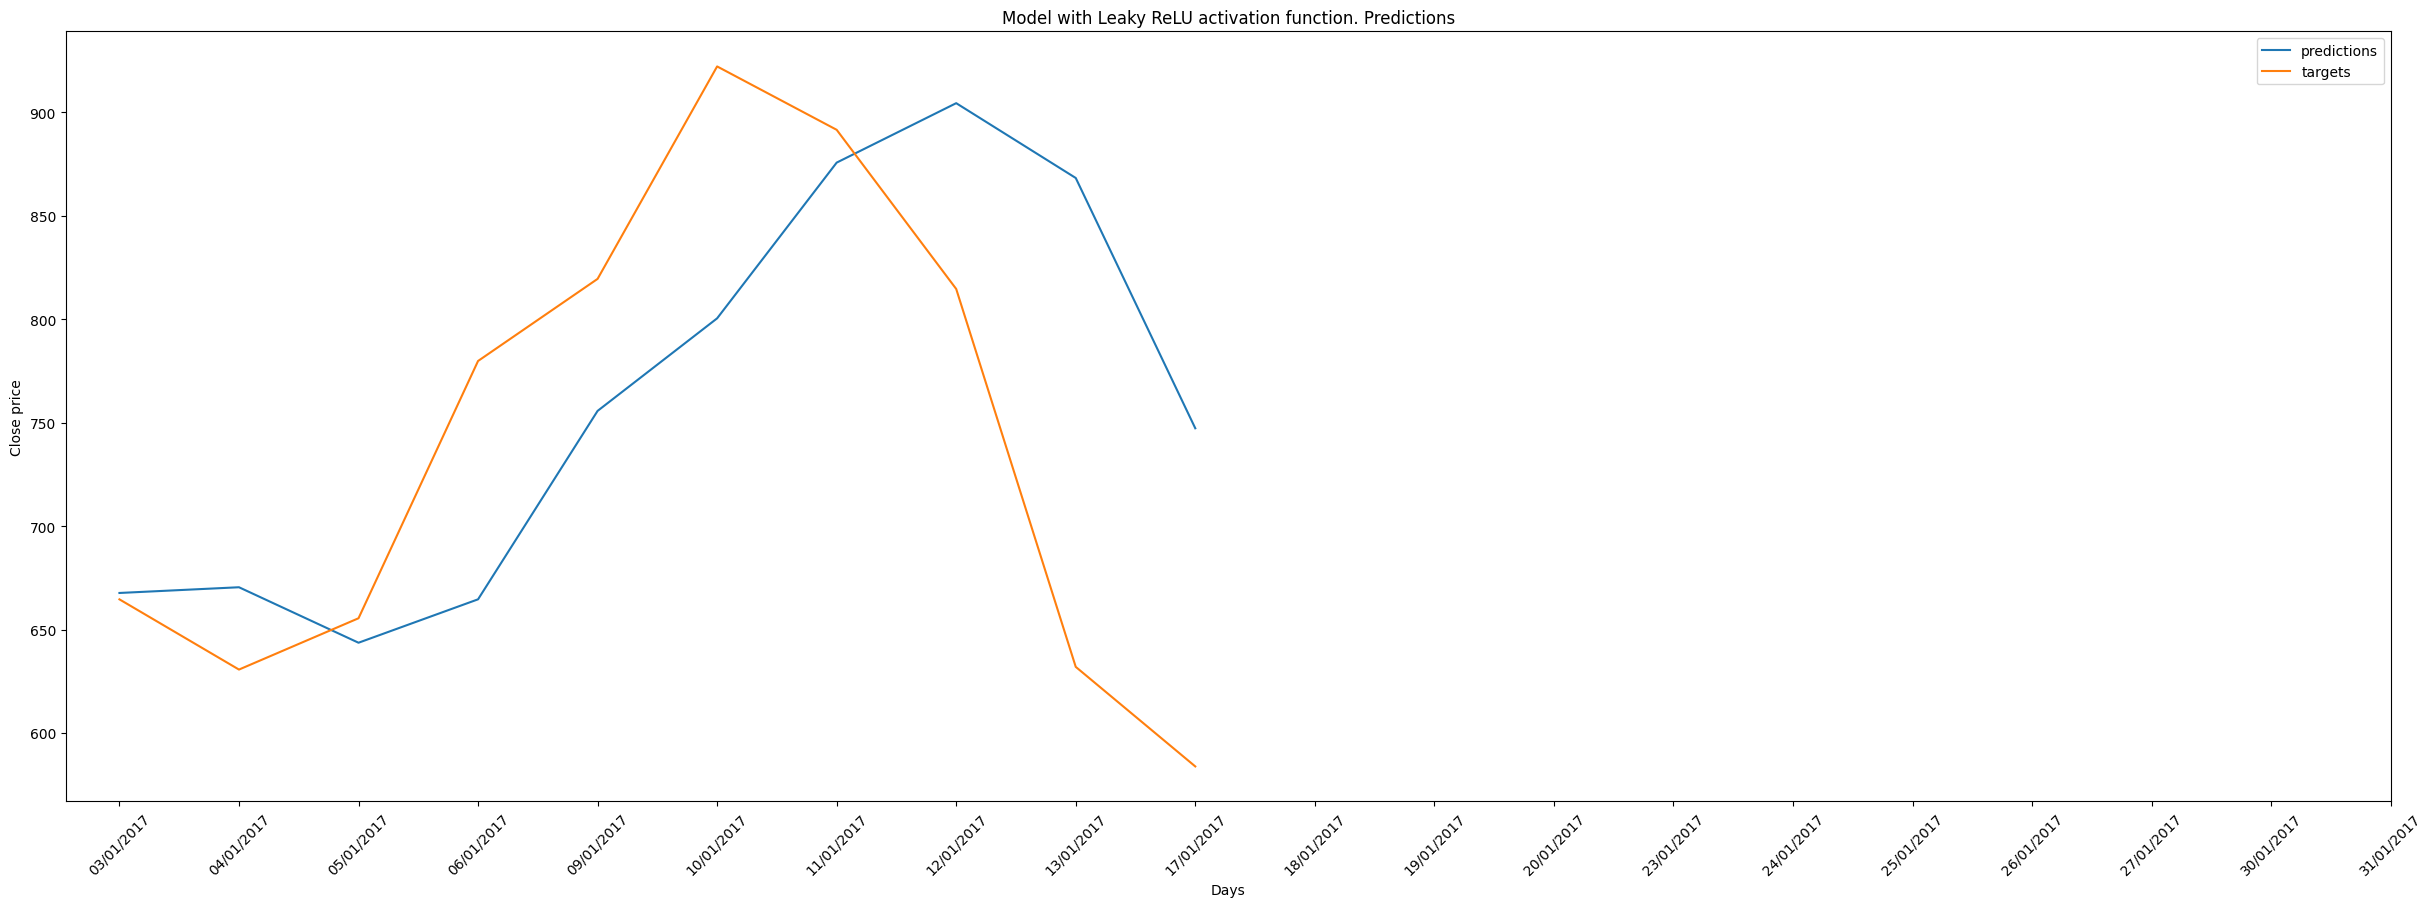

Epoch 1/20, Loss: 0.1063
Epoch 2/20, Loss: 0.0034
Epoch 3/20, Loss: 0.0022
Epoch 4/20, Loss: 0.0017
Epoch 5/20, Loss: 0.0015
Epoch 6/20, Loss: 0.0015
Epoch 7/20, Loss: 0.0014
Epoch 8/20, Loss: 0.0014
Epoch 9/20, Loss: 0.0014
Epoch 10/20, Loss: 0.0014
Epoch 11/20, Loss: 0.0014
Epoch 12/20, Loss: 0.0014
Epoch 13/20, Loss: 0.0014
Epoch 14/20, Loss: 0.0013
Epoch 15/20, Loss: 0.0013
Epoch 16/20, Loss: 0.0013
Epoch 17/20, Loss: 0.0013
Epoch 18/20, Loss: 0.0013
Epoch 19/20, Loss: 0.0013
Epoch 20/20, Loss: 0.0013
Test RMSE: 113.2955


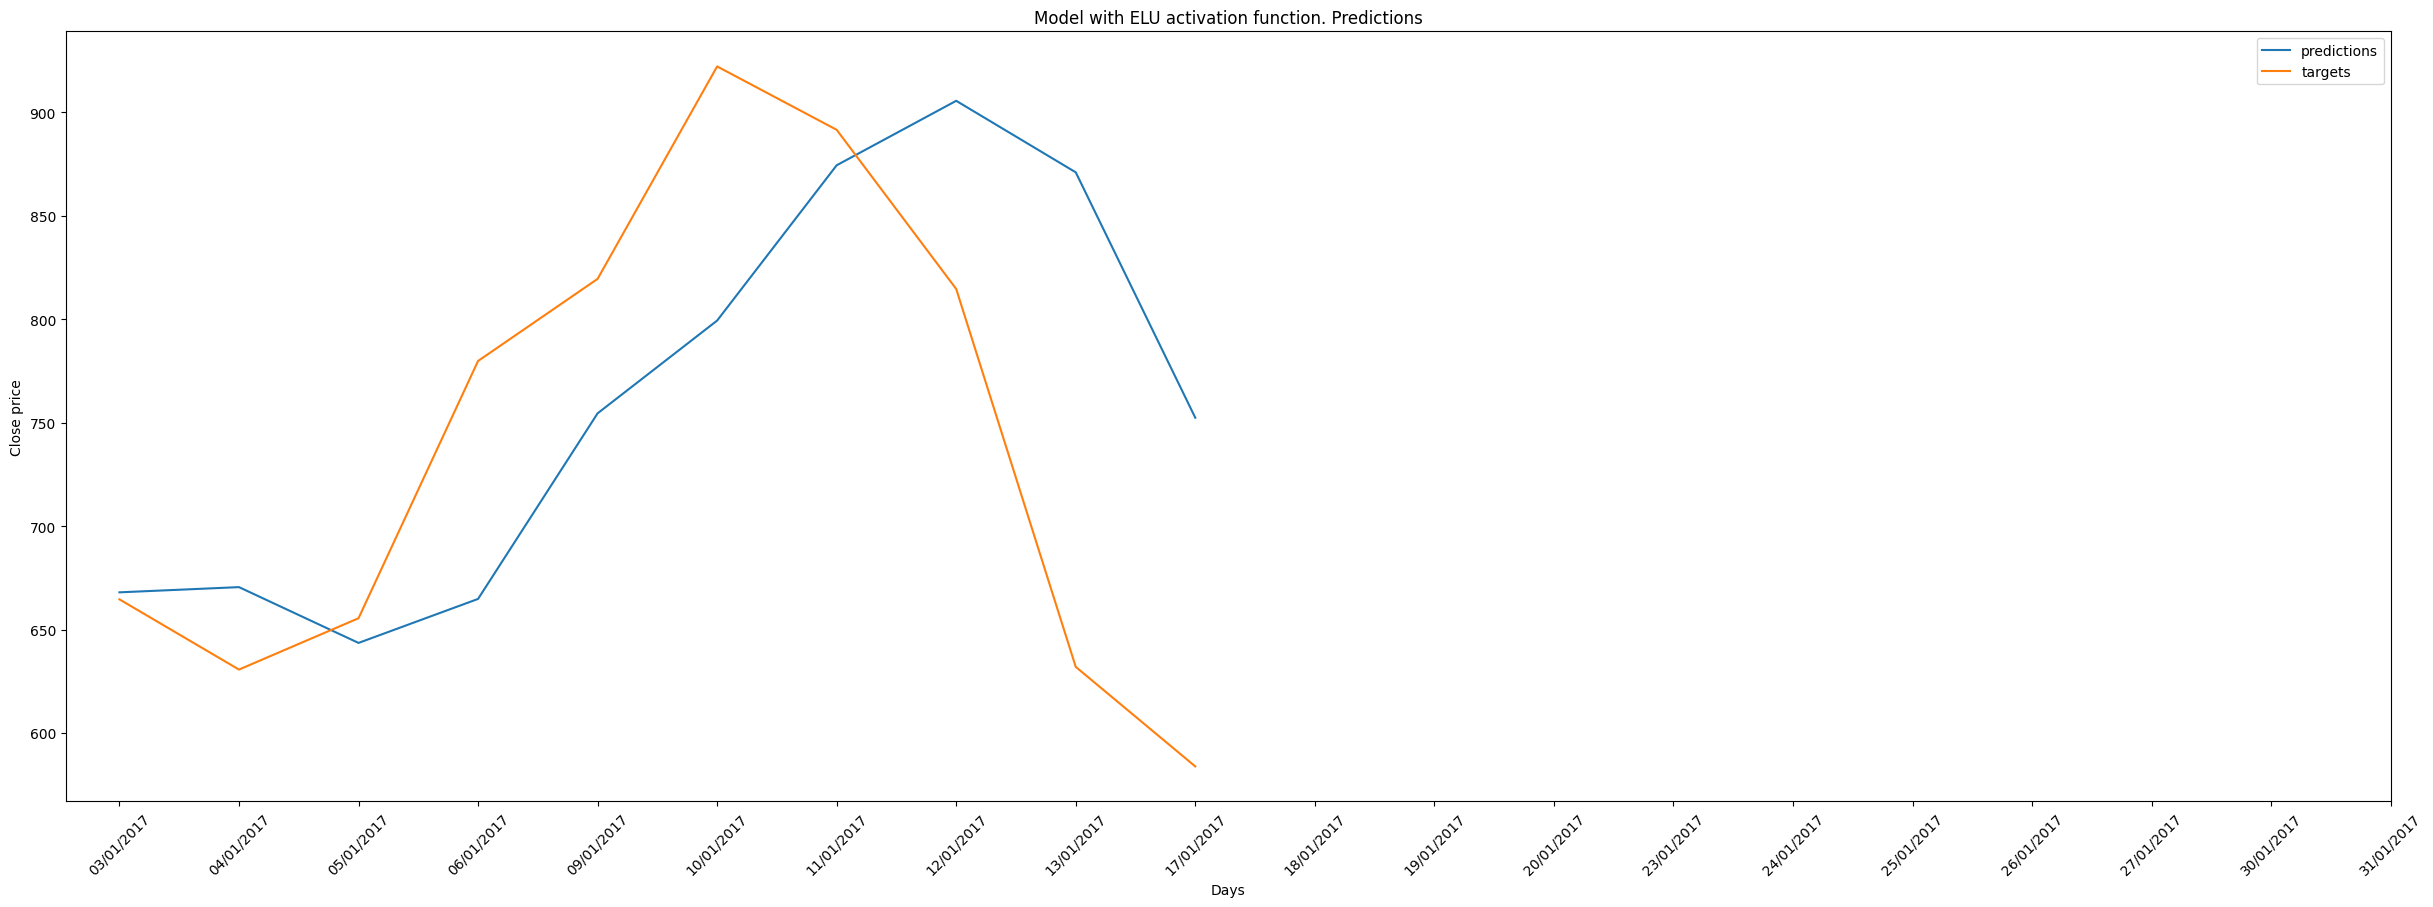

Epoch 1/20, Loss: 0.1026
Epoch 2/20, Loss: 0.0044
Epoch 3/20, Loss: 0.0028
Epoch 4/20, Loss: 0.0023
Epoch 5/20, Loss: 0.0023
Epoch 6/20, Loss: 0.0022
Epoch 7/20, Loss: 0.0022
Epoch 8/20, Loss: 0.0021
Epoch 9/20, Loss: 0.0021
Epoch 10/20, Loss: 0.0020
Epoch 11/20, Loss: 0.0020
Epoch 12/20, Loss: 0.0020
Epoch 13/20, Loss: 0.0019
Epoch 14/20, Loss: 0.0019
Epoch 15/20, Loss: 0.0019
Epoch 16/20, Loss: 0.0019
Epoch 17/20, Loss: 0.0019
Epoch 18/20, Loss: 0.0019
Epoch 19/20, Loss: 0.0019
Epoch 20/20, Loss: 0.0019
Test RMSE: 92.6655


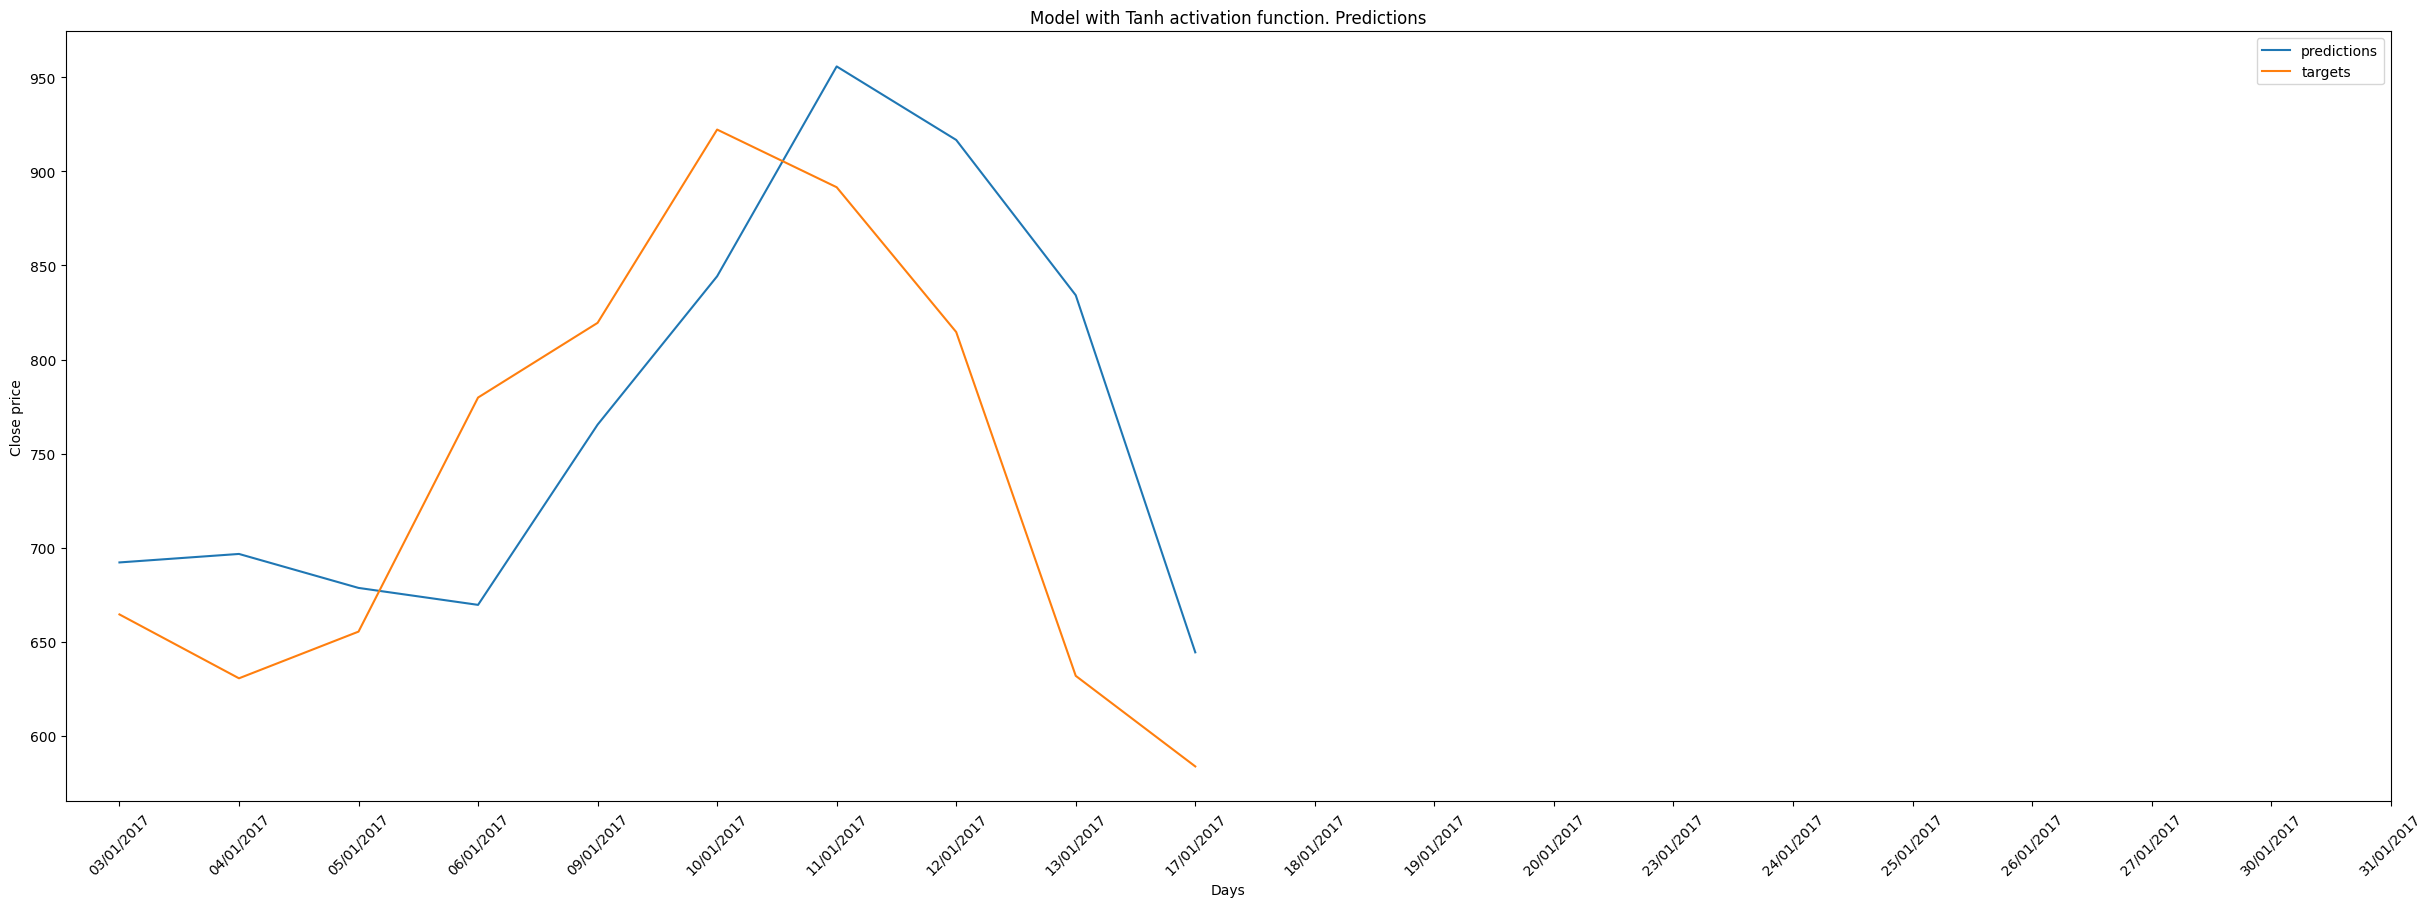

Epoch 1/20, Loss: 0.0738
Epoch 2/20, Loss: 0.0656
Epoch 3/20, Loss: 0.0352
Epoch 4/20, Loss: 0.0224
Epoch 5/20, Loss: 0.0179
Epoch 6/20, Loss: 0.0133
Epoch 7/20, Loss: 0.0077
Epoch 8/20, Loss: 0.0056
Epoch 9/20, Loss: 0.0055
Epoch 10/20, Loss: 0.0056
Epoch 11/20, Loss: 0.0056
Epoch 12/20, Loss: 0.0057
Epoch 13/20, Loss: 0.0057
Epoch 14/20, Loss: 0.0057
Epoch 15/20, Loss: 0.0058
Epoch 16/20, Loss: 0.0058
Epoch 17/20, Loss: 0.0058
Epoch 18/20, Loss: 0.0058
Epoch 19/20, Loss: 0.0059
Epoch 20/20, Loss: 0.0059
Test RMSE: 497.0980


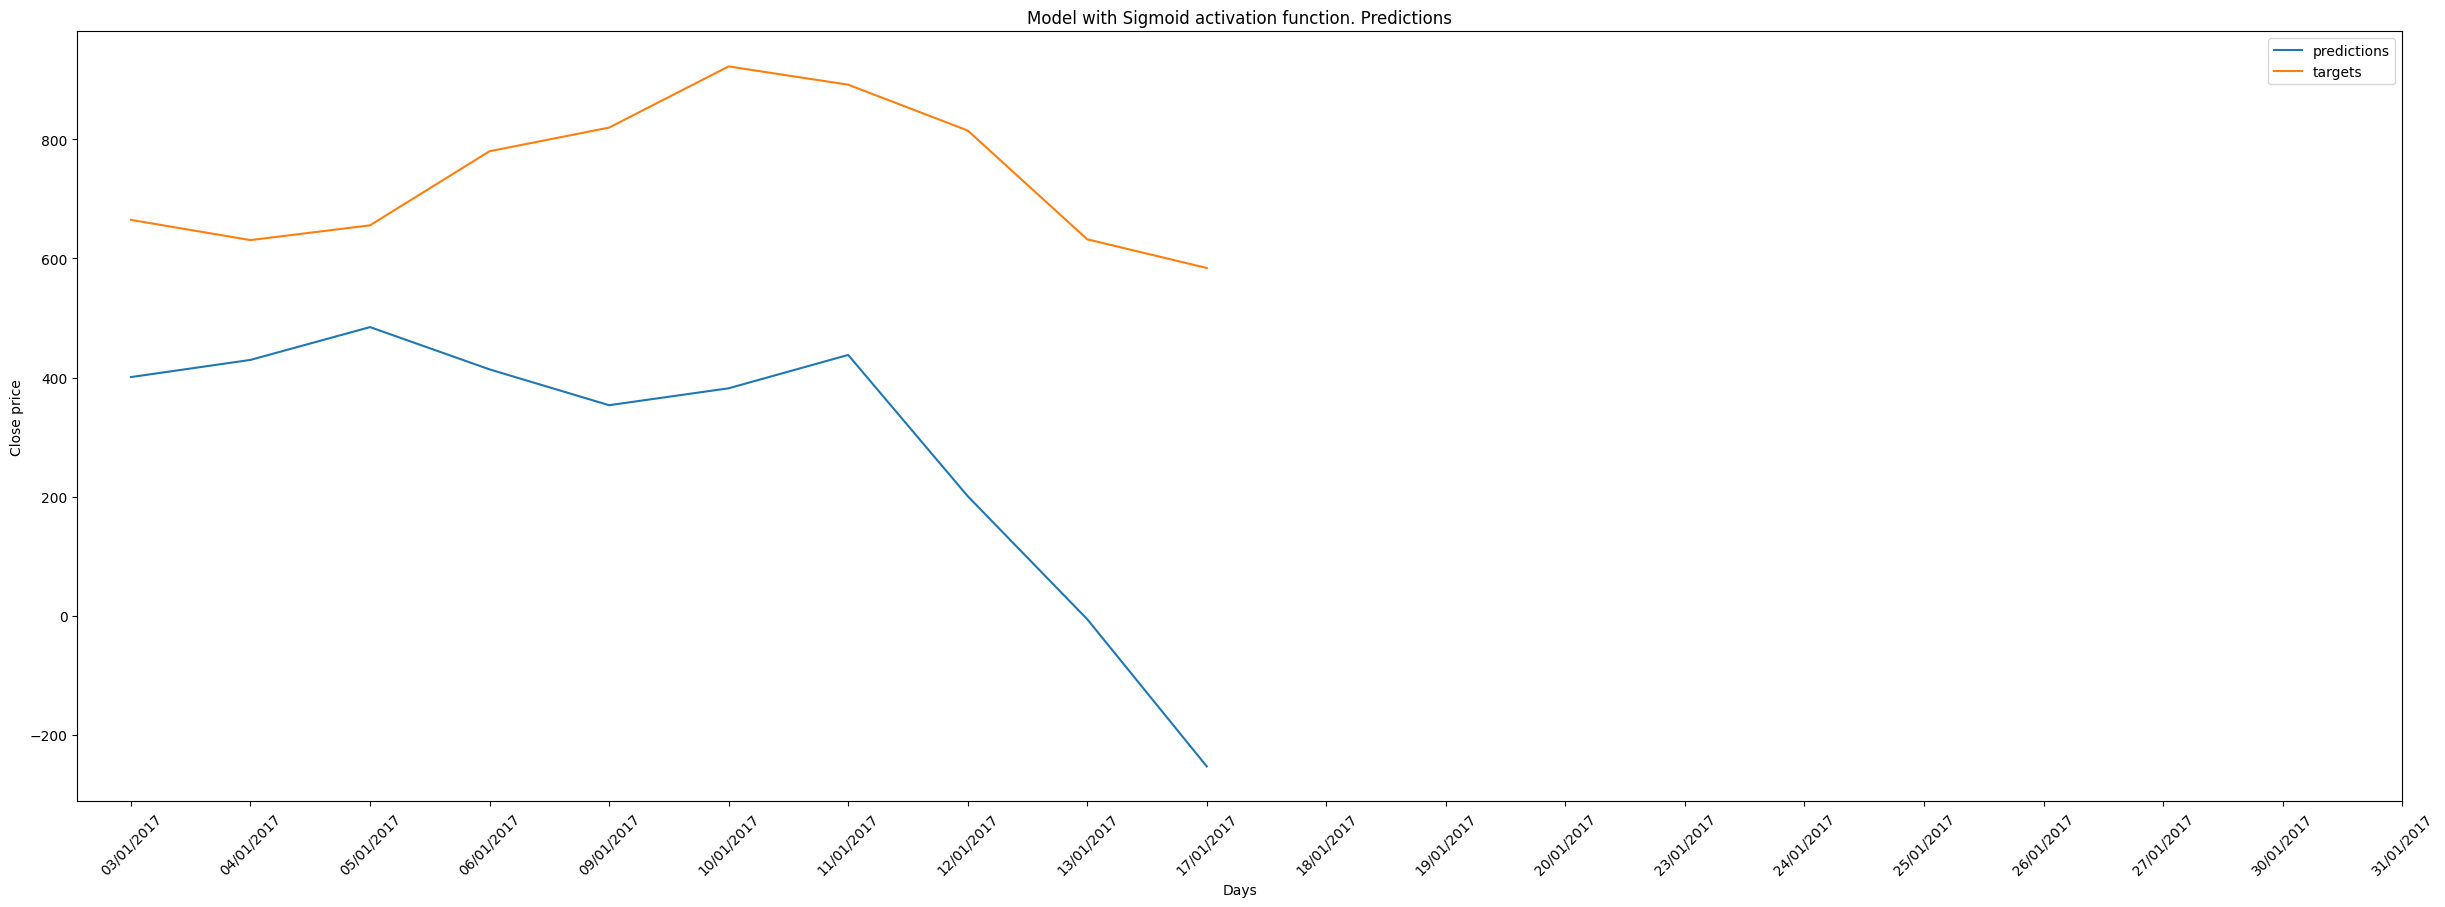

In [7]:
import matplotlib.pyplot as plt

from simple_rnn import SimpleRNN

# Load and prepare data
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)

# Define activation functions to test
activation_functions: dict[str, Callable[[float], float]] = {
    "ReLU": relu,
    "Leaky ReLU": leaky_relu,
    "ELU": elu,
    "Tanh": tanh,
    "Sigmoid": sigmoid,
}

for activation_function_name in activation_functions:
    activation_function = activation_functions[activation_function_name]
    # Initialize and train RNN
    rnn = SimpleRNN(
        input_size=train_data.shape[1] - 1,  # Minus 1 to remove date here
        hidden_size=30,
        activation_function=activation_function,
    )
    train_rnn(rnn, train_sequences, epochs=20, learning_rate=0.001)
    # Test the RNN (no training)
    predictions, targets = test_rnn(
        rnn, test_data, normalisation_params, sequence_length
    )

    plt.figure(figsize=(30, 10))
    plt.plot(predictions, label="predictions")
    plt.plot(targets, label="targets")
    plt.title(f"Model with {activation_function_name} activation function. Predictions")
    plt.xlabel("Days")
    plt.ylabel("Close price")

    plt.xticks(
        ticks=range(len(test_data)),
        labels=pd.to_datetime(test_data["Date"]).dt.strftime("%d/%m/%Y"),
        rotation=45,
    )
    plt.legend()
    plt.show()

## Test RNN on stock data

In [8]:
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)

rnn = SimpleRNN(
    input_size=train_data.shape[1] - 1,  # Minus 1 to remove date here
    hidden_size=30,
    activation_function=relu,
)
train_rnn(rnn, train_sequences, epochs=20, learning_rate=0.001)

Epoch 1/20, Loss: 0.0976
Epoch 2/20, Loss: 0.0033
Epoch 3/20, Loss: 0.0021
Epoch 4/20, Loss: 0.0017
Epoch 5/20, Loss: 0.0016
Epoch 6/20, Loss: 0.0015
Epoch 7/20, Loss: 0.0015
Epoch 8/20, Loss: 0.0014
Epoch 9/20, Loss: 0.0014
Epoch 10/20, Loss: 0.0014
Epoch 11/20, Loss: 0.0014
Epoch 12/20, Loss: 0.0014
Epoch 13/20, Loss: 0.0014
Epoch 14/20, Loss: 0.0014
Epoch 15/20, Loss: 0.0013
Epoch 16/20, Loss: 0.0013
Epoch 17/20, Loss: 0.0013
Epoch 18/20, Loss: 0.0013
Epoch 19/20, Loss: 0.0013
Epoch 20/20, Loss: 0.0013


In [13]:
from load_stock_data import load_stock_data

test_directory = Path(
    "/mnt/c/Users/chris/OneDrive/University/2024/Deep Learning Fundamentals/assignment3/stock_market_data/sp500/csv/"
)
test_data, _ = load_stock_data(test_directory, "INTU")

predictions, targets = test_rnn(rnn, test_data, normalisation_params, sequence_length)

plt.figure(figsize=(300, 100))
plt.plot(predictions, label="predictions")
plt.plot(targets, label="targets")
plt.title(f"Model with ReLU activation function. Predictions")
plt.xlabel("Days")
plt.ylabel("Close price")

plt.xticks(
    ticks=range(len(test_data)),
    labels=pd.to_datetime(test_data["Date"], dayfirst=True).dt.strftime("%m/%d/%Y"),
    rotation=45,
)
plt.legend()
plt.show()

Test RMSE: 5.2796
